# Report

## Introduction and Data

Diabetic retinopathy is a serious illness, which is expected to affect > 200 million people by the year 2025 [1]. It is an eye desease resulting in blindness for over 10000 people with diabetes per year [2]. In order to help these patients Boehringer Ingelheim is investing in Research and Development of biopharmaceuticals and is screening for new active ingredients, which has the potential to slow or even stop the progression of this desease [3]. A unique characteristic of these medications is the intravitreal application, which means that the drug product is injected directly into the vitreous humor, the gel-like substance inside the eye (see picture below).

<img src="../references/images/IntravitrealApplication.png" alt="Beispielbild" width="400">


*Picture: Illustration of the ocular anatomy and intravitreal injection for the treatment of ocular diseases [4]*



One major challenge of developing drug products, which are applied intravitreal, is the requirement for the low viscosity of the drug product solution. Viscosity is the measure of how easily a fluid flows; thicker liquids like honey have high viscosity, while thinner ones like water have low viscosity. It reflects the internal resistance of a liquid's molecules to movement or flow. A high viscosity of the drug product solution in the syringe results in a higher injection force necessary to apply the medication into the eye. The European Pharmacopoeia (EP) provides specific guidelines regarding the viscosity of intravitreal applied biopharmaceuticals to ensure safe and effective injection [5]. 

For this reason the viscosity is a very important measure and is determined several times during the early development stage for every new product. Viscosity is tested under different experiment conditions like temperature and product concentration. In order to reduce development time to the commercial launch of a new drug product and reduce costs for laboratory equipment and personnel, the long term motivation of this work is to predict the viscosity of every new agent without any experiments in the laboratory.

### Motivation

The aim of this study is to evaluate the influence of various predictors on the measured viscosity by developing a linear regression model. The first objective is to determine which predictor has the greatest impact on viscosity and identify any predictors that do not contribute to the model's predictive power. Additionally, the study seeks to quantify the magnitude of influence each selected predictor has on the measured viscosity. Finally, an important question to address is whether the developed model is suitable for predicting viscosity values based on the selected predictors, providing an early estimation of viscosity without requiring laboratory measurements.

### Data description

The data set, which will be explored in this work consists of viscosity data, whereas each observation of the data set corresponds to one measurement value. The data was collected as part of a characterization study for various biopharmaceutical products. These products consist of different types of proteins (IgG2, IgG4, Knob/Hole, DoppelMab), which have different characteristics like molecular weight, isoelectic point or extinction coefficient. In order to determine the effect of product concentration on the viscosity, each product was measured at two different concentrations (10 mg/mL, 62.5 mg/mL).  Furthermore, viscosity was measured at different temperatures (2°C - 40°C) to assess the impact of temperature variations. The data set consists of the following variables:



| Name  |   Description	| Role   	| Type   	|  Format 	|
|-------|---------------|-----------|-----------|-----------|
| viscosity_mPas  	| Measured viscosity, of the sample in mPas 	        | response  	    | numeric  	    | float  	|
| replicate  	| Number of replicate. Within each measurement, two individual measurements were conducted as technical replicates   	        | ID 	    | numeric  	    | int  	|
| entered_on  	| The date on which the measurement was conducted	        | predictor  	    |numeric  	    | date  	|
| instrument  	| Instrument, which was used to measure the viscosity   	        | predictor  	    | nominal  	    | category  	|
| temperature_c 	| The temperature at which the measurement was conducted  	        | predictor  	    | numeric  	    | float  	|
| product_concentration_mg_mL  	| Concentration of the product in the aqueous solution in mg/mL   	        | predictor  	    | numeric  	    | float  	|
| product  	| Internal product name as a unique code  	        | ID  	    | nominal  	    | category  	|
| protein_format  	| Protein format of the investigated product 	        | predictor  	    | nominal  	    | category  	|
| molecular_weight_kda  	| Molecular weight of the investigated product in kDa. A measure of the size of the protein   	        | predictor  	    | numeric  	    | float  	|
| extinction_coefficient_l_molcm  	| Extinction coefficient of the investigated product in L·mol⁻¹·cm⁻¹. A measure of the light absorption ability of the molecule 	        | predictor  	    | numeric  	    | float  	|
| isoelectric_point  	| Isoelectric point of the investigated product. A measure of the charge of the molecule	        | predictor  	    | numeric  	    | float  	|


### Data collection

The underlying measurements were conducted by laboratory personnel within the formulation development department at Boehringer Ingelheim. The measurement values were documented in the internal Laboratory Information Management System (LIMS) along with additional detailed experimental and contextual information, which also contain all explanatory data like the product characteristics etc. The data is stored in an Oracle SQL database and was extracted using targeted SQL queries. 

Since the data used contain confidential information of Boehringer Ingelheim, they have been modified to protect sensitive details. Some variables have been anonymized or altered in their structure without compromising the relevance of the data for the analysis.

### Setup

In [1228]:
import os
from pathlib import Path
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


### import Data

In [1229]:
# Import data from the csv-file "viscosity_data.csv"
df_all = pd.read_csv("../data/processed/viscosity_data.csv", sep=";")

### Data structure

In [1230]:
df_all.head()

,viscosity_mPas,replicate,entered_on,instrument,temperature_C,product_concentration_mg_mL,product,protein_format,molecular_weight_kDa,extinction_coefficient_L_molcm,isoelectric_point
0,3.93,1,15.03.2019,VISCOSIMETER_02,2,10.0,BI655300,IgG2,148830,220.42,8.54
1,4.28,2,16.03.2019,VISCOSIMETER_02,2,10.0,BI655300,IgG2,148830,220.42,8.54
2,3.42,1,15.03.2019,VISCOSIMETER_02,5,10.0,BI655300,IgG2,148830,220.42,8.54
3,3.69,2,15.03.2019,VISCOSIMETER_02,5,10.0,BI655300,IgG2,148830,220.42,8.54
4,2.89,1,15.03.2019,VISCOSIMETER_02,10,10.0,BI655300,IgG2,148830,220.42,8.54


In [1231]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   viscosity_mPas                  502 non-null    float64
 1   replicate                       502 non-null    int64  
 2   entered_on                      502 non-null    object 
 3   instrument                      502 non-null    object 
 4   temperature_C                   502 non-null    int64  
 5   product_concentration_mg_mL     502 non-null    float64
 6   product                         502 non-null    object 
 7   protein_format                  502 non-null    object 
 8   molecular_weight_kDa            502 non-null    int64  
 9   extinction_coefficient_L_molcm  502 non-null    float64
 10  isoelectric_point               502 non-null    float64
dtypes: float64(4), int64(3), object(4)
memory usage: 43.3+ KB


In [1232]:
#Search for empty data fields
print(df_all.isnull().sum())

viscosity_mPas                    0
replicate                         0
entered_on                        0
instrument                        0
temperature_C                     0
product_concentration_mg_mL       0
product                           0
protein_format                    0
molecular_weight_kDa              0
extinction_coefficient_L_molcm    0
isoelectric_point                 0
dtype: int64


### Data corrections

According to the literature there are three explanatory variables, which have an impact on the viscosity of the solution. According to the Arrhenius equation, a higher temperature generally decreases viscosity, because molecular movement increases, reducing intermolecular interactions [6]. Also the product concentration might have an impact on the viscosity, because molecules in solution interact more frequently, leading to increased resistance to flow [7] Additionally larger and more complex proteins, such as aggregates or conjugated proteins, tend to increase solution viscosity due to their size and interaction with other molecules in the solution [8], which indicates that the moleculare weight of the product might have an impact on the measured viscosity. According to literature the relationship of all three explanatory variables and the target variable is exponentell. In order to use the linear regression the Log Transformation is used. Therefore the target variable 'viscosity_mpas' is normalized by calculating the base-10 logarithm of the variable (log_viscosity).

In [1233]:
# change data type in order to make pandas functions more efficient
df_all['protein_format'] = pd.Categorical(df_all['protein_format'])

In [1234]:
# Make sure column names are lower case and eliminate spaces
df_all.columns = df_all.columns.str.lower()

In [1235]:
df_all['viscosity_mean'] = (
    df_all.groupby(['temperature_c', 'product_concentration_mg_ml', 'product'])['viscosity_mpas']
    .transform('mean')
)

In [1236]:
# Log-transformation of the target variable (without unit)
df_all['log_viscosity'] = np.log(df_all['viscosity_mean'])

In [1237]:
# For a better overview data set is reduced to the most interesting variables we want to examine
df = df_all.loc[0:502,['viscosity_mpas','protein_format','log_viscosity','temperature_c','product_concentration_mg_ml','molecular_weight_kda','extinction_coefficient_l_molcm','isoelectric_point']]

In [1238]:
df

,viscosity_mpas,protein_format,log_viscosity,temperature_c,product_concentration_mg_ml,molecular_weight_kda,extinction_coefficient_l_molcm,isoelectric_point
0,3.93,IgG2,1.412206,2,10.0,148830,220.42,8.54
1,4.28,IgG2,1.412206,2,10.0,148830,220.42,8.54
2,3.42,IgG2,1.268355,5,10.0,148830,220.42,8.54
3,3.69,IgG2,1.268355,5,10.0,148830,220.42,8.54
4,2.89,IgG2,1.101940,10,10.0,148830,220.42,8.54
...,...,...,...,...,...,...,...,...
497,5.22,DoppelMab,1.672413,30,62.5,206428,355.71,8.34
498,4.76,DoppelMab,1.535791,35,62.5,206428,355.71,8.34
499,4.53,DoppelMab,1.535791,35,62.5,206428,355.71,8.34
500,4.25,DoppelMab,1.418277,40,62.5,206428,355.71,8.34


### Descriptive statistics

In [1239]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
viscosity_mpas,502.0,3.894861,2.990443,0.540000,2.200000,3.165000,4.54750,27.870000
log_viscosity,502.0,1.182789,0.562044,-0.046044,0.813693,1.148988,1.51924,3.186559
temperature_c,502.0,20.203187,12.610650,2.000000,10.000000,20.000000,30.00000,40.000000
product_concentration_mg_ml,502.0,36.354582,26.275976,10.000000,10.000000,62.500000,62.50000,62.500000
molecular_weight_kda,502.0,161211.103586,22382.413980,146286.000000,148783.000000,149601.000000,155089.00000,206428.000000
extinction_coefficient_l_molcm,502.0,241.135538,50.327715,201.400000,207.360000,220.420000,236.92000,355.710000
isoelectric_point,502.0,8.094382,0.580659,6.970000,7.750000,8.270000,8.42000,9.360000


### Exploratory data analysis

In order to visualize the relationship between the explanatory variables and the response variable, charts were created with the training data. According to literature a linear correlation of all three parameters (temperature, product concentration, molecular weight) and the logarithm of the viscosity is expected. Although all three predictor variables take continuous numerical values, the dataset contains only a specific number of defined values for the independent variables. There exist only nine values of the temperature (2°C, 5°C, 10°C, 15°C, 20°C, 25°C, 30°C, 35°C, 40°C), two values of the product concentration (10 mg/mL, 62.5 mg/mL) and 14 values of the molecular weight. Therefore box plots were chosen to visualize the distribution of the response variable within these values of the predictor variables.

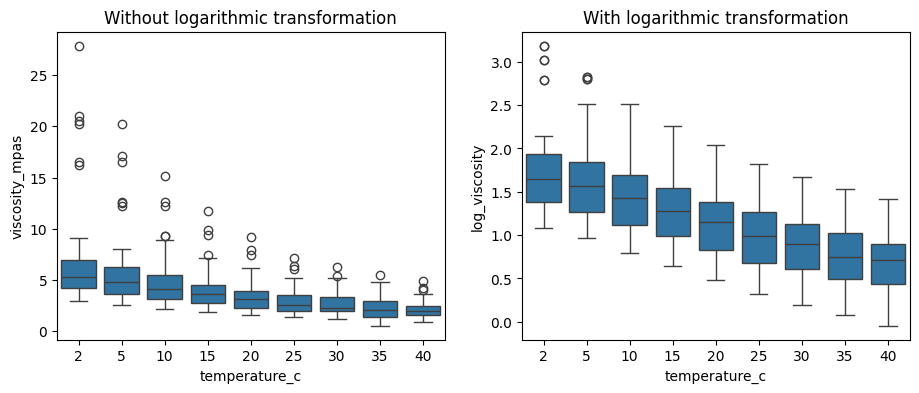

In [1240]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))  

sns.boxplot(data=df, x='temperature_c', y='viscosity_mpas', ax=axes[0])
axes[0].set_title("Without logarithmic transformation")

sns.boxplot(data=df, x='temperature_c', y='log_viscosity', ax=axes[1])
axes[1].set_title("With logarithmic transformation")

plt.show()

In the left box plot, the relationship between the measured viscosity in mPas and the temperature in °C is shown without log transformation of the response variable. A slightly negative trend is evident from the individual data points. As temperature increases, the measured viscosity decreases, indicating a negative association between the two variables. The high number of outliers above the whiskers and the longer upper whiskers indicate a right-skewed disctibution. The pattern of the data points suggests an exponential relationship between the two variables. These findings are consistent with the literature, which states that the viscosity of a fluid decreases exponentially as temperature rises [6].

In order to get a more symmetric distribution, reduce the impact of outliers and get a linear relationship a logarithmic transformation was done, which is shown in the right box plot. In this chart the relationship beween the base-10 logarithm of the viscosity (log_viscosity) and the temperature is shown. Although there are still outliers in the graph above the boxes, the distribution of the response variable appears to be more symmetric. The lengths of the lower and upper whiskers in the box plots have become more balanced and the chart suggests a moderate linear correlation between the two variables. 

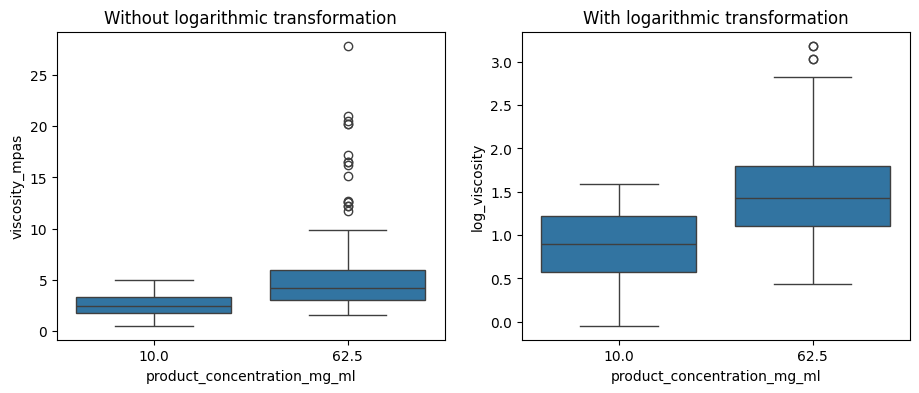

In [1241]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))  

sns.boxplot(data=df, x='product_concentration_mg_ml', y='viscosity_mpas', ax=axes[0])
axes[0].set_title("Without logarithmic transformation")

sns.boxplot(data=df, x='product_concentration_mg_ml', y='log_viscosity', ax=axes[1])
axes[1].set_title("With logarithmic transformation")

plt.show()

The left graph illustrates the relationship between measured viscosity (in mPas) and product concentration (in mg/mL). The presence of numerous outliers and the longer upper whiskers indicate a right-skewed distribution, similar to the graphs above.

The right graph shows the relationship between the base-10 logarithm of viscosity (log_viscosity) and product concentration (in mg/mL). Although only two concentration levels (10 mg/mL and 62.5 mg/mL) were analyzed, a clear positive correlation between the logarithm of viscosity and product concentration is observed. The median positions within the boxes suggest that the distribution of the response variable is more symmetric compared to the left graph (without normalization). This increased symmetry indicates that the relationship between product concentration and logarithmically transformed viscosity is linear, whereas the relationship with the untransformed viscosity follows an exponential pattern. These findings are consistent with the literature, which reports that the viscosity of protein solutions increases exponentially with rising protein concentration [7].

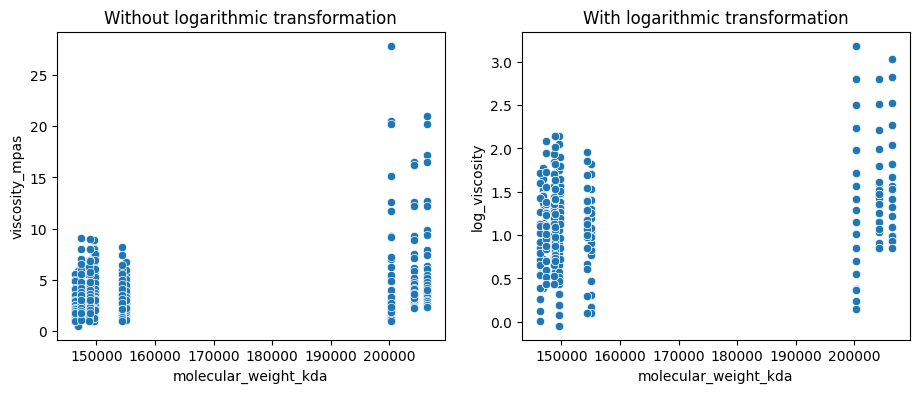

In [1242]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))  

sns.scatterplot(data=df, x='molecular_weight_kda', y='viscosity_mpas', ax=axes[0])
axes[0].set_title("Without logarithmic transformation")

sns.scatterplot(data=df, x='molecular_weight_kda', y='log_viscosity', ax=axes[1])
axes[1].set_title("With logarithmic transformation")

plt.show()

The left graph illustrates the relationship between measured viscosity (in mPas) and the molecular weight (in mg/mL). To achieve a continuous distribution of the data points along the x-axis, a scatter plot was chosen for visualization instead of a box plot. Nevertheless a right-skewed distribution especially at higher molecular weight is observed.

In the right graph the distriubution seems to be more symmatrical. In this graph the relationship between the logarithm of the measured viscosity (in mPas) and the molecular weight (in kDa) of the product is shown. Despite the dataset containing 14 different molecular weights, the predictor variable is not evenly distributed along the x-axis. The graph reveals that the molecular weights can be grouped into two main clusters: a smaller cluster between 140,000 kDa and 160,000 kDa, and a larger cluster between 200,000 kDa and 210,000 kDa. The logarithmically transformed viscosity of the heavier molecules appears to be higher than that of the smaller molecules, suggesting a positive association between molecular weight and logarithmically transformed viscosity. 

Besides the numerical predictors there is also a categorical variable, which might have an impact on the response variable. The protein format is the type of protein, which was examined during the measurements. This attribute consists of four different categories: IgG2, IgG4, Knob/Hole, DoppelMab. Before including this variable in the model development, the distribution of the data within the data set is determined:

In [1243]:
counts = df['protein_format'].value_counts()
counts

protein_format
IgG2         250
DoppelMab    108
IgG4          72
Knob/Hole     72
Name: count, dtype: int64

The variable protein_format contain a good distribution of data, which might be helpful to improve the model's accuracy. In the following chart the relationship between the protein format and the response variable will be visualized. To show the distribution of the data within the four categories boxplots were chosen.

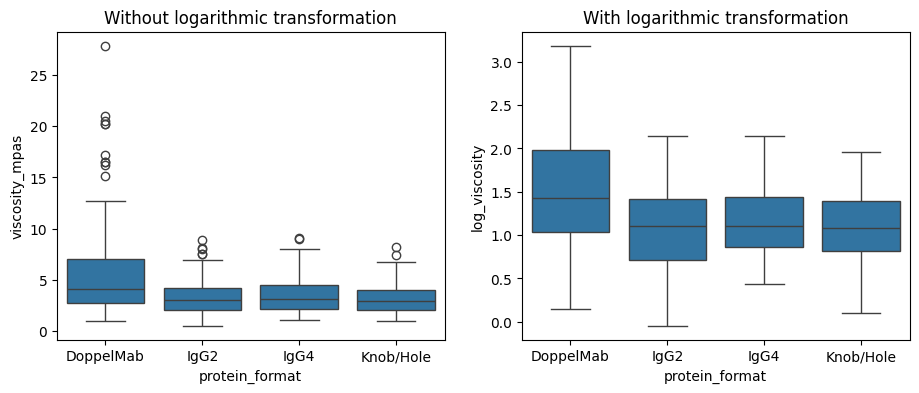

In [1244]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))  

sns.boxplot(data=df, x='protein_format', y='viscosity_mpas', ax=axes[0])
axes[0].set_title("Without logarithmic transformation")

sns.boxplot(data=df, x='protein_format', y='log_viscosity', ax=axes[1])
axes[1].set_title("With logarithmic transformation")

plt.show()

In the left graph the distribution of the viscosity values in mPas within the four categories of the protein format variable were shown. Like in the graphs with the numerical variables above a right skewed distribution is visible. The distribution in the right box plot (logarithmically transformed viscosity) seems to be more symmetrically

These variables can be transformed to numerical variables using the function pd.get_dummies:

In [1245]:
#get dummy numerical variables for categoric predictor
df = pd.get_dummies(df, columns=['protein_format'], drop_first= True)
#new columns were convert into integer data types
df['protein_format_IgG2'] = df['protein_format_IgG2'].astype(int)
df['protein_format_IgG4'] = df['protein_format_IgG4'].astype(int)
df['protein_format_Knob/Hole'] = df['protein_format_Knob/Hole'].astype(int)

## Methodology

### Logarithmic Transformation

The chart below is a correlation matrix, which is a tabular representation of the pairwise correlation coefficients between the response variables (viscosity_mpas), the logarithmic transformed response variable and all predictor variables. The correlation matrix indicates the strength and direction of the linear relationship between two variables, which will be helpful to discuss possible variable transformations.

In [1246]:
corr = df.corr(method='pearson').round(2)
corr_blues_transformation = corr[['viscosity_mpas','log_viscosity']].style.background_gradient(cmap='Blues', axis=None, gmap=corr.abs())
corr_blues_transformation

,viscosity_mpas,log_viscosity
viscosity_mpas,1.000000,0.870000
log_viscosity,0.870000,1.000000
temperature_c,-0.500000,-0.650000
product_concentration_mg_ml,0.430000,0.540000
molecular_weight_kda,0.360000,0.320000
extinction_coefficient_l_molcm,0.350000,0.300000
isoelectric_point,-0.160000,-0.200000
protein_format_IgG2,-0.210000,-0.200000
protein_format_IgG4,-0.030000,0.010000
protein_format_Knob/Hole,-0.090000,-0.090000



Like shown before in the exploratory data analysis the relationship between some of the predictors like the temperature and logarithmically transformed viscosity is linear, whereas the relationship with the untransformed viscosity follows an exponential pattern. The correlation matrix above confirms these findings, showing that the linear relationship between temperature and the logarithmically transformed viscosity (-0.63) is stronger than with the untransformed response variable (-0.5).

A similar improvement is observed for product_concentration_mg_ml, where the correlation coefficient increases by 0.09, from 0.43 to 0.52. This makes product concentration the second most strongly associated variable with the response variable. Additionally, there is a moderate positive correlation between molecular_weight_kda and the response variable (0.36). However, this decreases by 0.05, to 0.31, when the response variable is log-transformed.

Although the linear relationship with molecular weight appears slightly weaker after the transformation, the exploratory analysis revealed a right-skewed distribution of the predictor without logarithmic transformation and a more symmetric distribution with the logarithmically transformed outcome variable. This justifies the use of the logarithmically transformed response variable (log_viscosity) for modeling process in order to improve model fit and satisfy assumptions.



### Model selection

Based on the exploratory data analysis, a linear relationship was identified between the predictor variables and the logarithmically transformed response variable log_viscosity. Given this assumption and the continuous nature of the response variable, a linear regression model has been chosen for model development. This model is selected as a baseline due to its simplicity and interpretability, allowing for a clear understanding of the relationships in the data before exploring more complex modeling approaches.

### Multicollinearity

The chart below is a correlation matrix, which is a tabular representation of the pairwise correlation coefficients between the logarithmic transformed target variable (viscosity_log) and all  predictor variables in the dataset. The correlation matrix indicates the strength and direction of the linear relationship between two variables, which will be helpful to identify multicollinearity.

In [1247]:
corr_blues_all = corr.drop(columns=['viscosity_mpas']).style.background_gradient(cmap='Blues', axis=None, gmap=corr.abs())
corr_blues_all

,log_viscosity,temperature_c,product_concentration_mg_ml,molecular_weight_kda,extinction_coefficient_l_molcm,isoelectric_point,protein_format_IgG2,protein_format_IgG4,protein_format_Knob/Hole
viscosity_mpas,0.870000,-0.500000,0.430000,0.360000,0.350000,-0.160000,-0.210000,-0.030000,-0.090000
log_viscosity,1.000000,-0.650000,0.540000,0.320000,0.300000,-0.200000,-0.200000,0.010000,-0.090000
temperature_c,-0.650000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
product_concentration_mg_ml,0.540000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000
molecular_weight_kda,0.320000,0.000000,-0.000000,1.000000,0.980000,-0.320000,-0.570000,-0.240000,-0.120000
extinction_coefficient_l_molcm,0.300000,0.000000,-0.000000,0.980000,1.000000,-0.190000,-0.590000,-0.250000,-0.040000
isoelectric_point,-0.200000,0.000000,-0.000000,-0.320000,-0.190000,1.000000,0.280000,-0.480000,0.510000
protein_format_IgG2,-0.200000,-0.000000,0.000000,-0.570000,-0.590000,0.280000,1.000000,-0.410000,-0.410000
protein_format_IgG4,0.010000,0.000000,-0.000000,-0.240000,-0.250000,-0.480000,-0.410000,1.000000,-0.170000
protein_format_Knob/Hole,-0.090000,0.000000,-0.000000,-0.120000,-0.040000,0.510000,-0.410000,-0.170000,1.000000


The correlation matrix above reveals significant relationships among several predictor variables. For example, the correlation coefficient between molecular_weight_kda and extinction_coefficient_l_molcm is 0.98, indicating strong collinearity and a very high positive association. Similarly, the newly introduced predictor variable protein_format_IgG2 also shows a correlation with molecular_weight_kda. From a biochemical perspective, this is expected, as one of the primary differences between protein formats is their molecular weight.

In contrast, no multicollinearity is observed between the temperature and any other predictor variable. The same is true for the product concentration (product_concentration_mg_ml). However, care must be taken when handling the other predictor variables during model development. A stepwise selection approach, where collinear predictor variables are added or removed one at a time, could help identify the best combination of features to optimize the model’s predictive performance while minimizing redundancy.

In [1248]:
# select features
X = df.drop(columns=['viscosity_mpas','log_viscosity'])
# create response
y = df['log_viscosity']

### Train-Test Split

Before the stepwise selection of the candidate predictors the data set was split into training and test sets. This is a crucial step in linear regression model development (and in machine learning in general). The purpose is to ensure that the model is evaluated on unseen data, which helps assess its ability to generalize beyond the data it was trained on. Normally the train-test split is done before exploratory data analysis Performing in order to prevent data leakage by ensuring that insights gained during EDA do not influence the test set, preserving its role as unseen data for unbiased model evaluation.

However in this work the exploratory data analysis wasa conducted before splitting the data in order to streamline the preprocessing and analysis process without switching between subsets, which reduces complexity of the work and maximizes data insights.

In [1249]:
# use a test size of 0,2 and random state 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# use your training data to make a pandas dataframe
df_train = pd.DataFrame(X_train.copy())

# add your training labels to the data
df_train = df_train.join(pd.DataFrame(y_train))

### Feature Scaling

As shown in the descriptive statistics in the introduction, the numeric attributes in the dataframe differ significantly in scale. For instance, the temperature predictor ranges from 2°C to 40°C, while the molecular weight spans from 146286.00 kDa to 206428.00 kDa. In models with regularization such as Ridge or Lasso regression a feature scaling like standardization is useful in order to improve the numerical stability to ensure similar magnitudes of all predictors, which enhances the predictive power of the model. Since this study uses a linear regression model without regularization, the underlying relationship between the predictors and the response variable remains unchanged. Scaling would only affect the magnitude of the coefficients. While this could help compare the relative impact of predictors on model prediction, the absolute influence of each predictor on the response variable is more relevant for our research question.

### Feature Selection

As seen in the correlation matrix above the predictors temperature and product concentration have the biggest influence on the response variable without any collinearity with other variables. Besides these two predictors all other explanatory variables, which could have an impact on the model are included in the selection process.

In order to to identify the most relevant predictors for the model a forward selection is made. It begins with an empty model and iteratively adds one feature at a time, selecting the one that improves the model's performance the most. Adjusted R² is used as a selection criterion. It begins with an empty model and iteratively adds one feature at a time, selecting the one that increases the adjusted R-sq of the model the most.  At each step, the selected features are retained, and the process repeats until no remaining features improve the adjusted R-sq of the model. 

Adjusted R-squared measures the proportion of variance explained by the model, adjusted for the number of predictors. Unlike R-squared, it accounts for model complexity, preventing overfitting by penalizing the addition of less-informative predictors.

In [1250]:
def adjusted_r2(model, X, y):
    # Calculates the adjusted R²-value
    n = len(y)
    p = X.shape[1]
    r2 = model.score(X, y)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def forward_selection(X, y):
    # Run through forward selection based on the adjusted R² 
    selected_features = []
    remaining_features = list(X.columns)
    best_adjusted_r2 = -np.inf
    final_model = None
    
    results = []  # List to store results for the DataFrame
    
    step = 0
    while remaining_features:
        adjusted_r2_scores = {}
        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_subset = X[current_features]
            model = LinearRegression()
            model.fit(X_subset, y)
            adj_r2 = adjusted_r2(model, X_subset, y)
            adjusted_r2_scores[feature] = adj_r2
        
        # Add best feature
        best_feature = max(adjusted_r2_scores, key=adjusted_r2_scores.get)
        if adjusted_r2_scores[best_feature] > best_adjusted_r2:
            best_adjusted_r2 = adjusted_r2_scores[best_feature]
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            final_model = LinearRegression().fit(X[selected_features], y)
            step += 1
            
            # Add to results list
            results.append({'Feature': best_feature, 'Adjusted R²': best_adjusted_r2})
            
        else:
            break
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return selected_features, best_adjusted_r2, final_model, results_df


### Model Evaluation with Cross Validation

In order to evaluate the generalization ability of the regression model, a cross-validation is performed by testing it on unseen data. It helps identify overfitting or underfitting by splitting the dataset into multiple folds, ensuring the model is trained and tested on different subsets of the data. In this work the dataset is splitted into five folds. This process provides a more reliable estimate of the model's performance compared to a single train-test split, ensuring robustness and better predictive accuracy. For every fold the average magnitude of prediction errors is quantified with the root mean squared error (RMSE). In this work the RMSE is preferred over MSE because it is in the same unit as the target (mPas) variable, making it more interpretable and directly comparable to the original data.

## Results

### Selected predictors

In [1251]:
# Application on train data:
selected_features, best_adj_r2, final_model, results_df = forward_selection(X_train, y_train)

results_df.rename_axis("Step")
results_df.index += 1
results_df

,Feature,Adjusted R²
1,temperature_c,0.422911
2,product_concentration_mg_ml,0.701966
3,molecular_weight_kda,0.809469
4,isoelectric_point,0.819556
5,protein_format_IgG4,0.820035


### Regression formula of the model

In order to evaluate the final model the regression formula is printed. It contains the regression coefficients of all predictors and the intercept of the regression model. 
Because standardized predictors were used for the model, the coefficients represent the effect of a one standard deviation change in the predictor on the target variable, regardless of the original units. This allows for a direct comparison of the relative importance of the predictors, but does not provide absolute statements about the target variable in the original scale.

In [1252]:
coefficients = final_model.coef_
intercept = final_model.intercept_

model_formula = "log_viscosity = " + " + ".join([f"{coef:.9f} * {col}" for coef, col in zip(coefficients, selected_features)]) + f" + {intercept:.2f}"
print("Final regression formula :", model_formula)

Final regression formula : log_viscosity = -0.029449446 * temperature_c + 0.011481378 * product_concentration_mg_ml + 0.000007713 * molecular_weight_kda + -0.082691408 * isoelectric_point + 0.063440362 * protein_format_IgG4 + 0.77


The given regression formula represents the relationship between the transformed target variable (log_viscosity) and the predictors in the final model. Since the predictors are not standardized, the coefficients cannot be directly compared in terms of their contribution to the model's predictive power. Instead, we focus on determining the actual influence of each predictor on the response variable.

A regression coefficient of -0.030 for temperature suggests that for every 1°C increase in temperature, the transformed viscosity value decreases by 0.030. As shown by the correlation matrix and the adjusted R-squared in the forward selection of the predictors in previous chapters, temperature has the strongest effect on measured viscosity.

The second most significant predictor, according to the adjusted R-squared in the forward selection of predictors, is product concentration, with a regression coefficient of 0.011. This means that for every 1 mg/mL increase in concentration, the log-transformed target variable increases by 0.011, confirming their positive linear relationship.

A regression coefficient of 0.070 for the predictor protein_format_igG4 indicates that if the examined protein is an IgG4 antibody, the transformed measured viscosity will be 0.070 higher compared to any other protein format.

The intercept of 0.84 represents the predicted value of the transformed target variable when all predictors are zero.


### Assessing the Predictive Performance of the Model

In the following, the model's predictions are generated for the test data using the selected features. The predicted values are initially in the transformed logarithmic scale and are retransformed back to the original viscosity scale using the exponential function. 

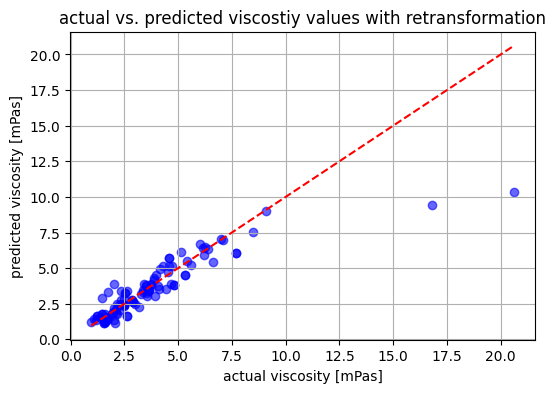

In [1253]:
# Vorhersagen des Modells
X_test_subset = X_test[selected_features]
y_pred_log = final_model.predict(X_test_subset)

#Retransformation of the prediction
y_test_original = np.exp(y_test)
y_pred = np.exp(y_pred_log)

# Scatterplot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_original, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')  
plt.xlabel("actual viscosity [mPas]")
plt.ylabel("predicted viscosity [mPas]")
plt.title("actual vs. predicted viscostiy values with retransformation")
plt.grid()
plt.show()


In the scatter plot above the actual measured viscosity values are compared with the predicted ones, where the blue points represent the predictions and the red dashed line indicates perfect prediction (where actual equals predicted). The plot helps to visualize how well the model's predictions align with the observed values.

In the lower scale range between 0 and 10 mPas, it can be observed that all predicted viscosity values (blue points) are positioned within a range of less than 2 mPas around the red line. This indicates that within the given test data, the predicted values are approximately equal to the actual measured values. In this range, the predictive power of the regression model appears to be very strong for the underlying test data. However, outside of this range, two blue data points at measured viscosities of approximately 16 mPas and 20 mPas are clearly ca. 7 mPas respectively ca. 10 mPas below the red line. Therefore, the predicted viscosity values from the model are significantly lower than the actual measured values.

### Model Validation

In the following a 5-fold cross-validation is performed to evaluate the predictive performance of a linear regression model. The target variable is in a logarithmic scale, and the features are standardized using StandardScaler before training the model. For each fold, the model is trained on the scaled training data and predictions are made on the scaled test data, followed by a retransformation of the predicted values from the logarithmic scale to the original scale. For every fold the root mean squared error (RMSE) is then calculated.

In [1254]:
# Initialization
y_log = y
X = df[selected_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Set up 5-fold cross-validation
scaler = StandardScaler()  # Standardize the features
model = LinearRegression()  # Define the linear regression model

# Store results
results = []  # List to store RMSE values

for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    
    # Split into training and testing data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions (logarithmic scale)
    y_pred_log = model.predict(X_test)
    
    # Retransform the predictions back to original scale
    y_pred = np.exp(y_pred_log)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(np.exp(y_test), y_pred))
    
    # Save results in the list
    results.append({"RMSE": rmse})

# Write results into a DataFrame
results_df = pd.DataFrame(results)

# Reset index to match the number of folds
results_df.index += 1

# Print the DataFrame with a nice background gradient
results_df.style.background_gradient(cmap='Blues')


,RMSE
1,1.403598
2,1.744624
3,0.921143
4,1.423001
5,1.988043


In [1255]:
# calculate statistics
results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE,5.0,1.496081,0.402569,0.921143,1.403598,1.423001,1.744624,1.988043


The five RMSE values from the 5-fold cross-validation range from 0.94 to 2.08, showing some variation in the model's performance across different data subsets. The lowest RMSE of 0.94 indicates strong prediction accuracy on that fold, while the highest RMSE of 2.08 suggests the model struggled more with that particular subset. The average RMSE across all folds is 1.60, which gives a general idea of the model’s overall predictive power. Despite the variation, most of the RMSE values fall within a similar range, suggesting a relatively consistent performance across the folds. The higher RMSE in one fold could be due to specific patterns or outliers in the test data, warranting further investigation.

## Discussion + Conclusion

The model demonstrates a relatively low error of an RMSE of 1,60 (in the same units as the target variable), suggesting reasonable prediction accuracy. 

With the target variable ranging from approximately 0.54 to 27.87, an average error of 1.44 is relatively small. Notably, in some cases, the difference between technical replicates (measurements under identical conditions) exceeds the model's average error, highlighting its potential utility.

To enhance the model further, additional model types could be tested in order to improve the prediction power of the model.

Was würde ich der PDB empfehlen. Modell verwenden warum warum nicht. wie gut?


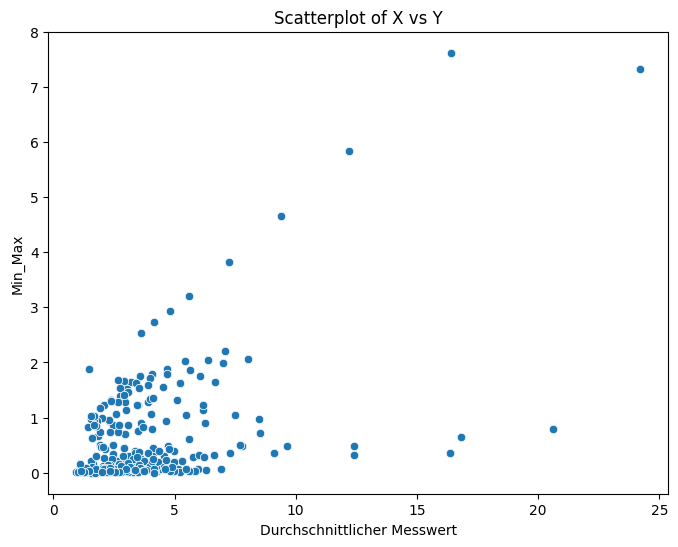

In [1256]:
df_all['viscosity_range'] = (
    df_all.groupby(['temperature_c', 'product_concentration_mg_ml', 'product'])['viscosity_mpas']
    .transform(lambda x: x.max() - x.min())
)

df_all['viscosity_mean'] = (
    df_all.groupby(['temperature_c', 'product_concentration_mg_ml', 'product'])['viscosity_mpas']
    .transform('mean')
)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='viscosity_mean', y='viscosity_range', data=df_all)
plt.title('Scatterplot of X vs Y')
plt.xlabel('Durchschnittlicher Messwert')
plt.ylabel('Min_Max')
plt.show()

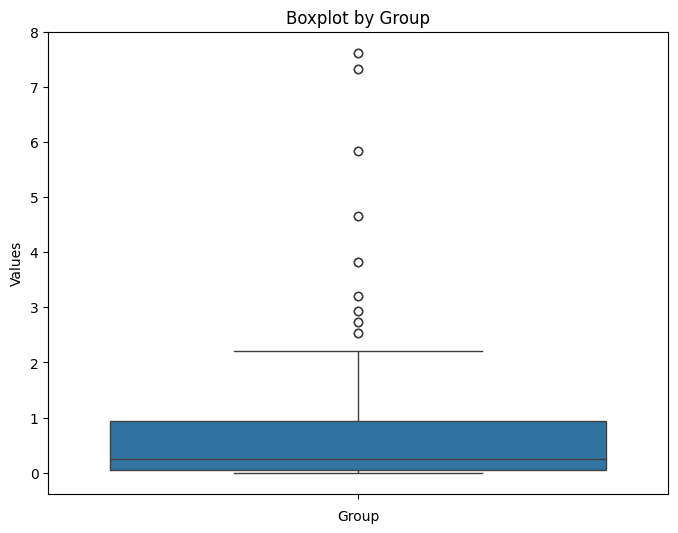

In [1257]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='viscosity_range', data=df_all)
plt.title('Boxplot by Group')
plt.xlabel('Group')
plt.ylabel('Values')
plt.show()

In [1258]:
df_all['viscosity_range'].describe().T

count    502.000000
mean       0.641594
std        1.003416
min        0.000000
25%        0.052500
50%        0.240000
75%        0.937500
max        7.620000
Name: viscosity_range, dtype: float64

## Bibiography

[1] Karin S Coyne, Mary Kay Margolis, Tessa Kennedy-Martin, Timothy M Baker, Ronald Klein, Matthew D Paul, Dennis A Revicki, The impact of diabetic retinopathy: perspectives from patient focus groups, Family Practice, Volume 21, Issue 4, August 2004, Pages 447–453.

[2] Donald S. Fong, Frederick L. Rerres, Lloyd P. Aiello, Ronald Klein, Diabetic Retinopathy, Diabetes Care, Volume 27, Number 10, October 2004

[3] Produkt Portfolio Boehringer Ingelheim, 2023, https://unternehmensbericht.boehringer-ingelheim.de/2023/download/BOE_GB23_Produktportfolio_DE_safe.pdf

[4] Parenky AC, Wadhwa S, Chen HH, Bhalla AS, Graham KS, Shameem M. Container Closure and Delivery Considerations for Intravitreal Drug Administration. AAPS PharmSciTech. 2021 Mar 11;22(3):100. doi: 10.1208/s12249-021-01949-4. PMID: 33709236; PMCID: PMC7952281.

[5] European Directorate for the Quality of Medicines & HealthCare. European Pharmacopoeia. 10th ed., Council of Europe, 2020. www.edqm.eu/en/european-pharmacopoeia-pharmacopoeia-europe.

[6] Arrhenius S. The Viscosity of Solutions. Biochem J. 1917 Aug;11(2):112-33. doi: 10.1042/bj0110112. PMID: 16742728; PMCID: PMC1258811.

[7] Wozniak, Spencer, and Michael Feig. "Diffusion and Viscosity in Mixed Protein Solutions." The Journal of Physical Chemistry B, vol. 128, no. 47, 2024

[8] Woldeyes, M. A., Josephson, L. L., Leiske, D. L., Galush, W. J., Roberts, C. J., & Furst, E. M. (2018). Viscosities and protein interactions of bispecific antibodies and their monospecific mixtures. Molecular Pharmaceutics, 15(10), 4252-4261.